# Waveguides - Ex8

### Ronen shekel

### ID 309987493 

In [122]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib ipympl
from scipy.optimize import fsolve
from mpl_toolkits.mplot3d import Axes3D 

# Q1
* Given a rectangular waveguide, find $\kappa_x, \kappa_y, \gamma_x, \gamma_y$, and also $\beta$ according to both Marcatili and Kumar. 
* We find solutions for $\kappa_x$ only for p=1,2, and q=1,2. 
* However, we find that the mode for q=2, p=2 is not guided from the condition of $k_0 \cdot n_0 < \beta < k_0 \cdot n_1$.  
* Ex has two contibutions, one proportional to Hy, and ont to its second derivative. We show numerically that the second contribution is negligent (more than 10 orders of magnitude smaller) so don't calculate it, and for drawing Ex we use the expression for Hy. For Ex in the corners we assume a double exponential decay, though we did not really discuss this in class. 

In [116]:
a = 2.5e-6
d = 3e-6 
n1 = 1.5
n0 = 1.47
wl = 1.55e-6
k0 = 2*np.pi/wl 

eps = np.finfo(float).eps

def get_kappa_gamma_x(a, p, n0, n1, k0, initial_guesses=0, plot=True):
    def gamma(kappa_x):
        return np.sqrt(k0**2*(n1**2-n0**2) - kappa_x**2)
    RHS = lambda k: (p-1)*(np.pi/2) + np.arctan((n1**2*gamma(k)) / (n0**2*k + eps))  # eps to not divide by zero 
    diff_func = lambda k: RHS(k) - k*a
    
    if plot:
        fig, ax = plt.subplots()
        X = np.linspace(0, 1.5e6, 1000)
        ax.plot(X, RHS(X))
        ax.plot(X, X*a)
    
    kappa_x = fsolve(diff_func, initial_guesses, xtol=1e-12, maxfev=5000)
    gamma_x = gamma(kappa_x)
    return kappa_x[0], gamma_x[0]

def get_kappa_gamma_y(d, q, n0, n1, k0, initial_guesses=0, plot=True):
    def gamma(kappa_y):
        return np.sqrt(k0**2*(n1**2-n0**2) - kappa_y**2)
    RHS = lambda k: (q-1)*(np.pi/2) + np.arctan(gamma(k) / (k + eps))  # eps to not divide by zero 
    diff_func = lambda k: RHS(k) - k*d
    
    if plot:
        fig, ax = plt.subplots()
        X = np.linspace(0, 1.5e6, 1000)
        ax.plot(X, RHS(X))
        ax.plot(X, X*a)
    
    kappa_y = fsolve(diff_func, initial_guesses, xtol=1e-12, maxfev=5000)
    gamma_y = gamma(kappa_y)
    return kappa_y[0], gamma_y[0]

### get $\kappa_x$s and $\gamma_x$s

In [102]:
kappa_xs = []
gamma_xs = []

for p in [1, 2]:
    x0 = 0.5*p/a  # initial guess, but a bit smaller so we won't get to bad regime 
    kx, gx = get_kappa_gamma_x(a, p, n0, n1, k0, x0, False)
    kappa_xs.append(kx)
    gamma_xs.append(gx)
print(f'{kappa_xs=}')
print(f'{gamma_xs=}')

kappa_xs=[473300.3012259952, 919414.5482063676]
gamma_xs=[1113596.8582268092, 786630.806884474]


### get $\kappa_y$s and $\gamma_y$s

In [103]:
kappa_ys = []
gamma_ys = []

for q in [1, 2]:
    x0 = 0.5*q/d
    ky, gy = get_kappa_gamma_y(d, q, n0, n1, k0, x0, False)
    kappa_ys.append(ky)
    gamma_ys.append(gy)
print(f'{kappa_ys=}')
print(f'{gamma_ys=}')

kappa_ys=[408739.3343813237, 804687.0677512473]
gamma_ys=[1138878.0858031954, 903653.6177026777]


### get $\beta$s

In [105]:
betas = np.zeros((len(kappa_xs), len(kappa_ys)))
for i in range(len(kappa_xs)):
    for j in range(len(kappa_ys)):
        betas[i, j] = np.sqrt(k0**2*n1**2 - kappa_xs[i]**2 - kappa_ys[j]**2)
print(f'{betas=}')

betas=array([[6048257.80378251, 6008408.19414597],
       [5996675.12249106, 5956480.4281696 ]])


### Check which betas will be guided 

In [148]:
for beta in betas.flatten():
    if not(k0*n0 < beta and beta < k0*n1):
        print(f'{beta=:.5f} not good solution')

beta=5956480.42817 not good solution


In [147]:
q = 2
p = 2
np.sqrt(k0**2*n1**2 - kappa_xs[p-1]**2 - kappa_ys[q-1]**2)

5956480.4281696025

In [ ]:
# TODO: betas kumar 

### Assert the second derivative factor is negligible. 

In [120]:
eps0 = 8.854e-12
mu0 = 4*np.pi*1e-7
c = 3e8
omega = c*k0 
beta = betas[0, 0]  # They are all the saae order of magnitude 
kappa_x = kappa_xs[0]  # They are all the saae order of magnitude
# SEcond derivative gives a factor of kappa_x 
prefactor_DXX = kappa_x**2/omega*eps0*beta

prefactor_main = omega*mu0/beta
print(f'{prefactor_DXX=}')
print(f'{prefactor_main=}')

prefactor_DXX=9.864474373991942e-09
prefactor_main=252.6672737950321


### Draw $E_x$ 
Which is pesky, since we need to do this separately for different regions 

In [180]:
def Ex_mode_kumar(X, Y, p, q, kappa_x, kappa_y, gamma_x, gamma_y, a, d):   
    # phi, psi shift based on p,q
    phi = (p - 1)*np.pi/2
    psi = (q - 1)*np.pi/2
    ExField = np.zeros_like(X, dtype=complex)

    # core region
    ic = (np.abs(X) <= a) & (np.abs(Y) <= d)
    ExField[ic] = np.cos(kappa_x[p-1]*X[ic] - phi) * np.cos(kappa_y[q-1]*Y[ic] - psi)

    # above core
    uY = (np.abs(X) <= a) & (Y > d)
    ExField[uY] = np.cos(kappa_x[p-1]*X[uY] - phi) * np.cos(kappa_y[q-1]*d - psi) \
                  * np.exp(-gamma_y[q-1] * (Y[uY] - d))

    # below core
    lY = (np.abs(X) <= a) & (Y < -d)
    ExField[lY] = np.cos(kappa_x[p-1]*X[lY] - phi) * np.cos(kappa_y[q-1]*d - psi) \
                  * np.exp(-gamma_y[q-1] * (-d - Y[lY]))

    # right side
    rX = (X > a) & (np.abs(Y) <= d)
    ExField[rX] = np.cos(kappa_x[p-1]*a - phi) * np.cos(kappa_y[q-1]*Y[rX] - psi) \
                  * np.exp(-gamma_x[p-1] * (X[rX] - a))

    # left side
    lX = (X < -a) & (np.abs(Y) <= d)
    ExField[lX] = np.cos(kappa_x[p-1]*a - phi) * np.cos(kappa_y[q-1]*Y[lX] - psi) \
                  * np.exp(-gamma_x[p-1] * (-a - X[lX]))

    # corners
    c1 = (X > a) & (Y > d)
    ExField[c1] = np.cos(kappa_x[p-1]*a - phi) * np.cos(kappa_y[q-1]*d - psi) \
                  * np.exp(-gamma_x[p-1] * (X[c1] - a)) * np.exp(-gamma_y[q-1] * (Y[c1] - d))

    c2 = (X > a) & (Y < -d)
    ExField[c2] = np.cos(kappa_x[p-1]*a - phi) * np.cos(kappa_y[q-1]*d - psi) \
                  * np.exp(-gamma_x[p-1] * (X[c2] - a)) * np.exp(-gamma_y[q-1] * (-d - Y[c2]))

    c3 = (X < -a) & (Y > d)
    ExField[c3] = np.cos(kappa_x[p-1]*a - phi) * np.cos(kappa_y[q-1]*d - psi) \
                  * np.exp(-gamma_x[p-1] * (-a - X[c3])) * np.exp(-gamma_y[q-1] * (Y[c3] - d))

    c4 = (X < -a) & (Y < -d)
    ExField[c4] = np.cos(kappa_x[p-1]*a - phi) * np.cos(kappa_y[q-1]*d - psi) \
                  * np.exp(-gamma_x[p-1] * (-a - X[c4])) * np.exp(-gamma_y[q-1] * (-d - Y[c4]))
    
    ExField /= np.sqrt((np.abs(ExField)**2).sum())

    return ExField

def plot_Ex_mode(X, Y, ExField, a, d, title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

    c = ax1.contourf(X, Y, np.abs(ExField)**2, 50, cmap='jet')
    plt.colorbar(c, ax=ax1)
    ax1.add_patch(plt.Rectangle((-a, -d), 2*a, 2*d, facecolor='gray', alpha=0.5))
    ax1.set_aspect('equal')
    ax1.set_title(title)

    # 3D surface of intensity
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(X, Y, np.abs(ExField)**2, cmap='jet', linewidth=0)
    ax2.set_title(title)

    plt.tight_layout()
    plt.show()


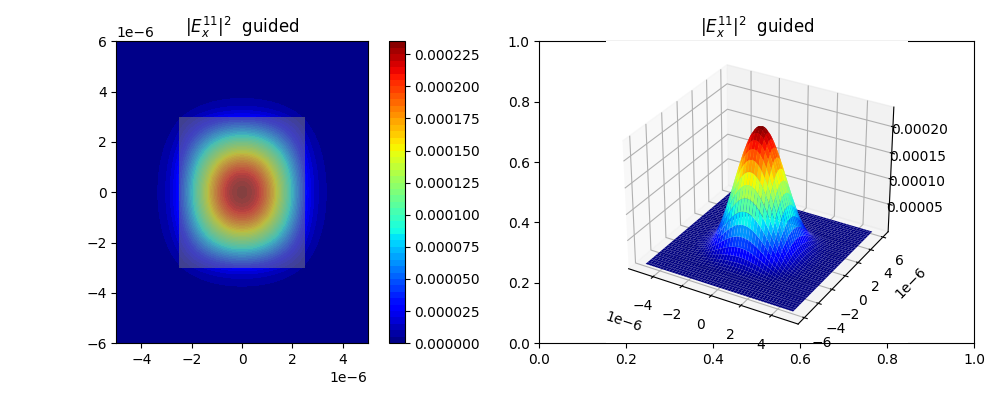

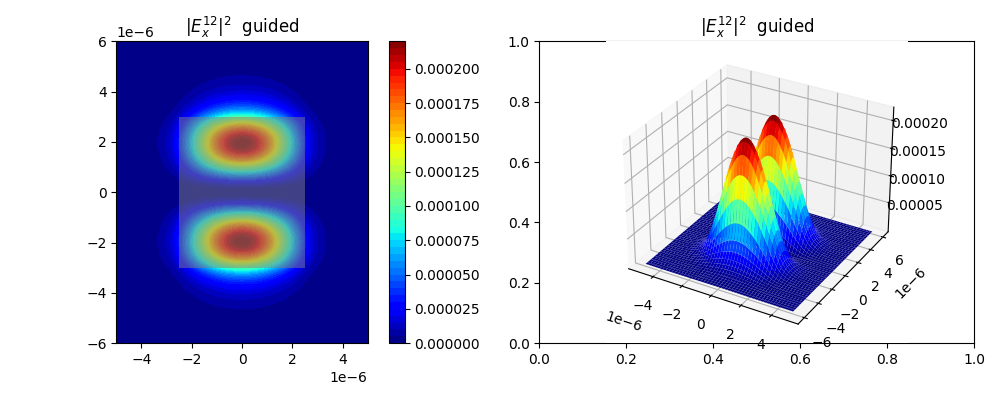

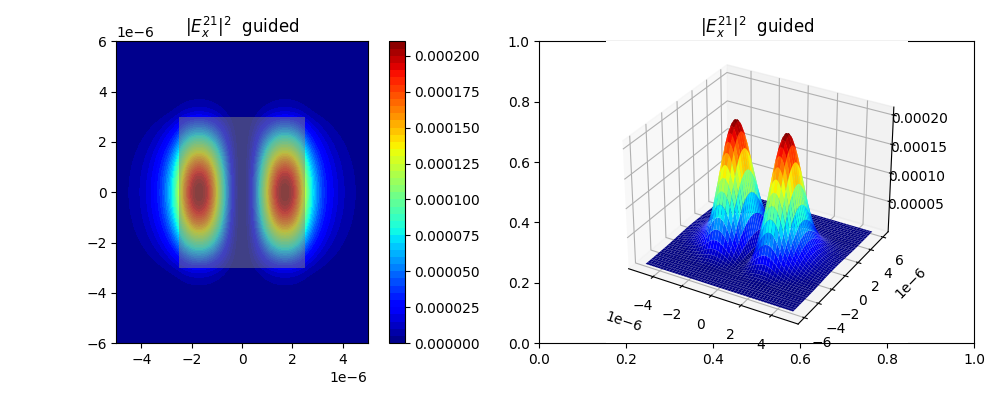

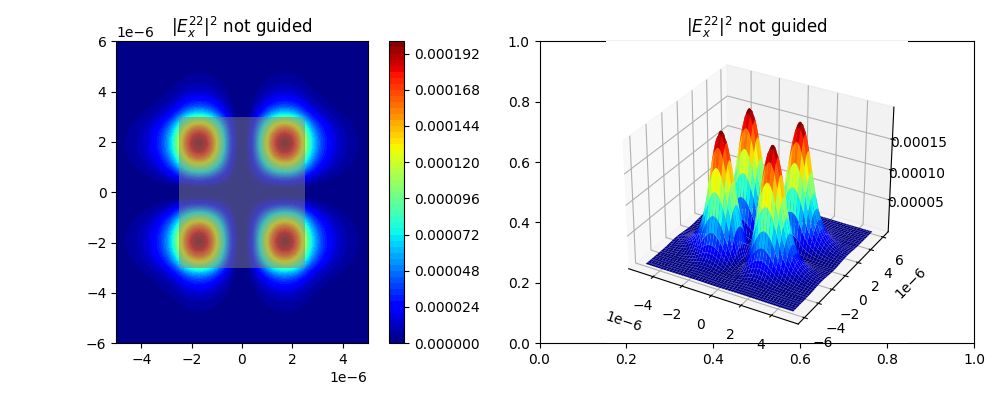

In [182]:
x_vals = np.linspace(-2*a, 2*a, 200)
y_vals = np.linspace(-2*d, 2*d, 200)
X, Y = np.meshgrid(x_vals, y_vals)

plt.close('all')
for (p, q) in [(1, 1), (1,2), (2,1), (2,2)]:
    E = Ex_mode_kumar(X, Y, p, q, kappa_xs, kappa_ys, gamma_xs, gamma_ys, a, d)

    not_str = ''
    if p == 2 and q == 2:
        not_str = 'not'
    title = rf"$|E_x^{{{p}{q}}}|^2$ {not_str} guided"
    plot_Ex_mode(X, Y, E, a, d, title)

### Find the b parameter from $n_{eff}$.   

In [153]:
# TODO: calculate b parameter from n_eff. 

# Q2
## A
Calculate the basic mode according to Kumar , for $h$ values of 4,5,6,7,8 $\mu m$, where $h$ is the size of a side. 

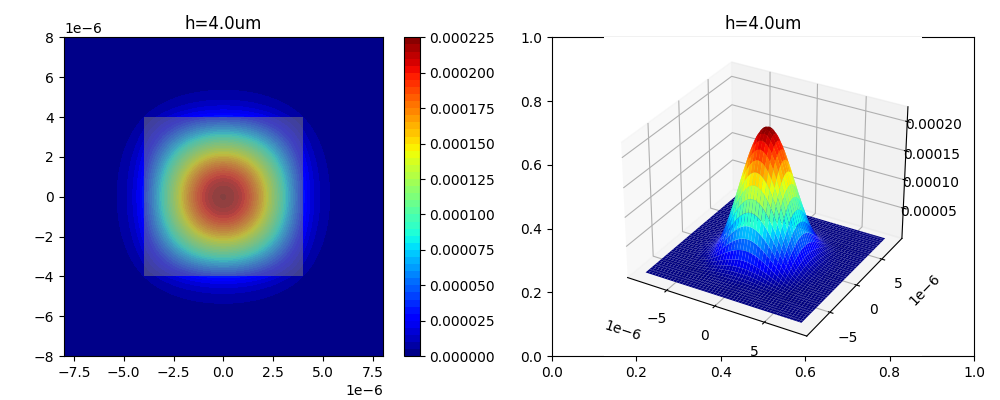

C:\Users\owner\AppData\Local\Temp\ipykernel_164\993315408.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  etas[i] = (fiber_mode * E.conj()).sum()
C:\Users\owner\AppData\Local\Temp\ipykernel_164\1101749355.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))


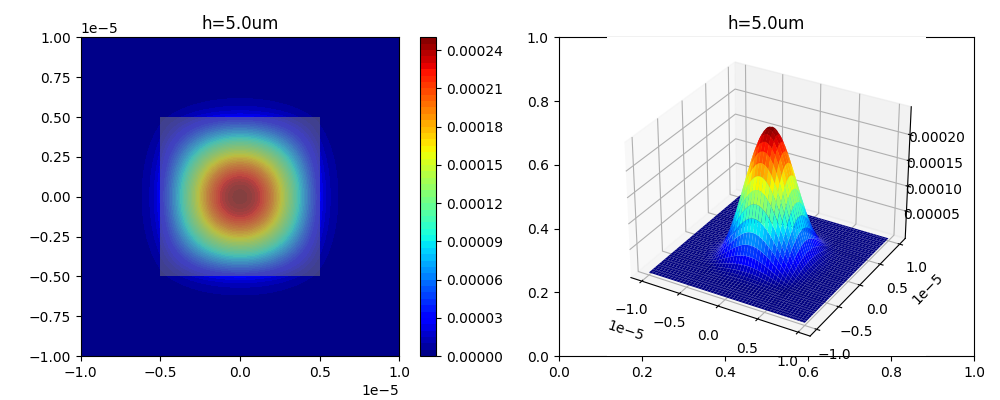

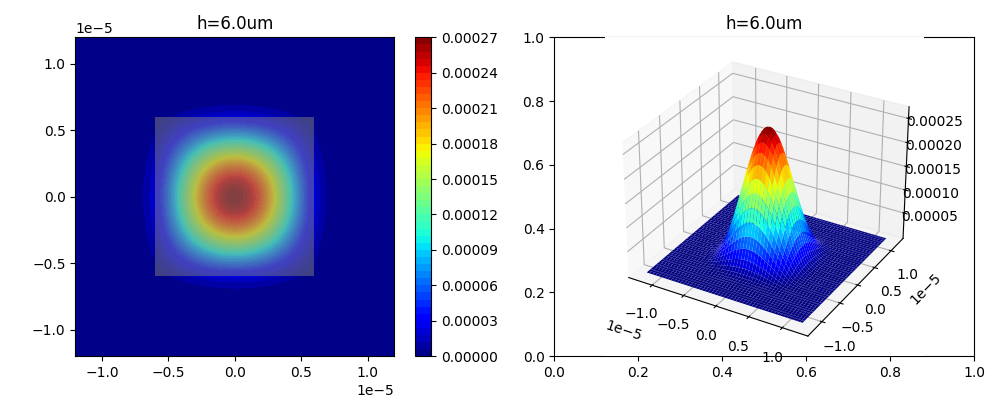

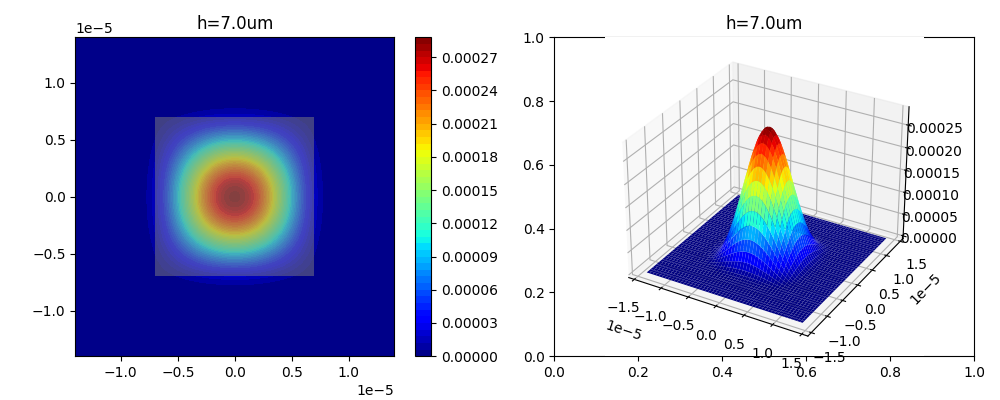

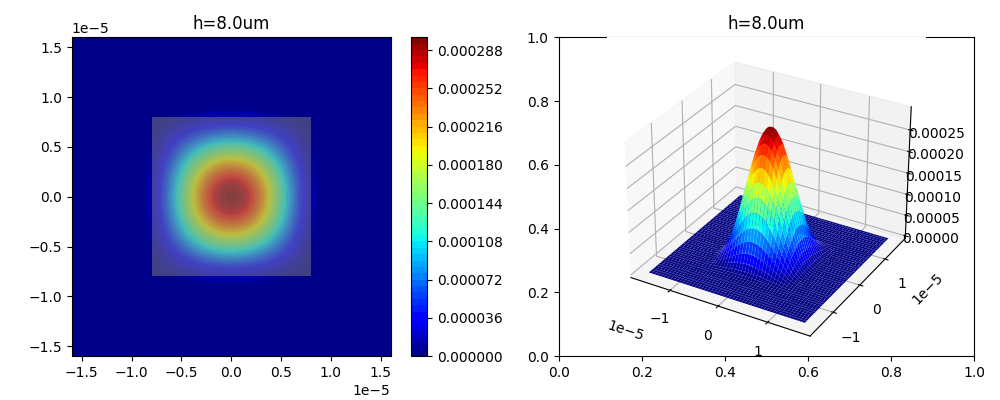

etas=array([0.90587822, 0.93037363, 0.94476451, 0.95392459, 0.96012668])


In [186]:
hs = np.arange(4,9) * 1e-6
n0 = 1.458
n1 = 1.47 
wl = 1.55e-6 
k0 = 2*np.pi/wl 

etas = np.zeros_like(hs)
# Create fiber mode 
x_vals = np.linspace(-2*hs.max(), 2*hs.max(), 200)
y_vals = np.linspace(-2*hs.max(), 2*hs.max(), 200)
X, Y = np.meshgrid(x_vals, y_vals)
R = np.sqrt(X**2 + Y**2)
waist = 5.25e-6 
fiber_mode = np.exp(-R**2/(waist**2))
fiber_mode /= np.sqrt((np.abs(fiber_mode)**2).sum())
# print((np.abs(fiber_mode)**2).sum())  # check normalization 

for i, h in enumerate(hs):
    p = 1 
    q = 1 
    x0 = 0 # 0.5/h 
    kappa_x, gamma_x = get_kappa_gamma_x(h, p, n0, n1, k0, x0, False)
    kappa_y, gamma_y = get_kappa_gamma_y(h, q, n0, n1, k0, x0, False)
    
    x_vals = np.linspace(-2*h, 2*h, 200)
    y_vals = np.linspace(-2*h, 2*h, 200)
    X, Y = np.meshgrid(x_vals, y_vals)
    
    E = Ex_mode_kumar(X, Y, p, q, [kappa_x], [kappa_y], [gamma_x], [gamma_y], h, h)
    # print((np.abs(E)**2).sum())  # check normalization 
    title = f'h={h*1e6:.1f}um'
    plot_Ex_mode(X, Y, E, h, h, title)
    
    etas[i] = (fiber_mode * E.conj()).sum()

hs=array([4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06])
etas**2=array([0.82061536, 0.86559508, 0.89257999, 0.90997212, 0.92184323])


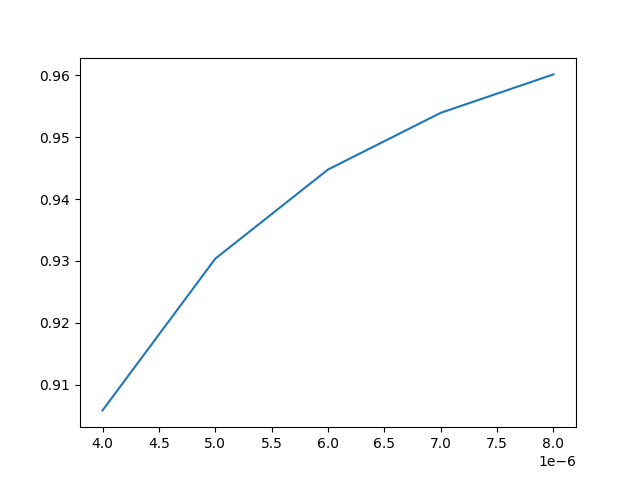

In [189]:
print(f'{hs=}')
print(f'{etas**2=}')
fig, ax = plt.subplots()
ax.plot(hs, etas)
# TODO: this and answer questions
# TODO: My etas differ a bit from the pdf solution. Chesk it out... maybe integration is less trivial? 